# FORECASTE

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import to_hex
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.arima.model import ARIMA
import seaborn as sns

from sklearn.metrics import mean_absolute_error, mean_squared_error

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 7)

## ARIMA Model
Step 1: Data Preparation & Stationarity Check<br>Step 2: Model Identification & Parameter Estimation<br>Step 3: Diagnostic Checking<br>Step 4: Forecasting & Accuracy Evaluation
ror terms


<img src="../img/residual_spark.png"/>

### Residual Analysis of Literacy Rate of India (1901 - 2011).
Residual spikes at certain points imply that the model may produce less reliable forecasts during similar anomalous periods in the future.<br>Perform a Chow Test or similar analysis to detect structural breaks in the time series. If breaks exist, consider splitting the data into pre- and post-break periods and model each segment separately.

## <br><br>Breaking the Series and Focusing on Post-Independence

In [2]:
df = pd.read_csv('../dataset/literacy.csv')
post_independence_data = df[df['year'] >= 1947][['year', 'persons']]
post_independence_data.reset_index(drop=True, inplace=True)
display(post_independence_data)

,year,persons
0,1951,18.33
1,1961,28.30
2,1971,34.45
3,1981,43.57
4,1991,52.21
5,2001,64.83
6,2011,74.04


### Adding 5 year interval and Interpolation

In [3]:
# Create a new range of years with 5-year gaps
min_year = post_independence_data['year'].min()
max_year = post_independence_data['year'].max()
new_years = list(range(min_year, max_year + 1, 5))

# Reindex the dataframe to include the new years
post_independence_data_reindexed = post_independence_data.set_index('year')
post_independence_data_reindexed = post_independence_data_reindexed.reindex(new_years)

# Interpolate the missing values
post_independence_data_reindexed['persons'] = post_independence_data_reindexed['persons'].interpolate(method='linear')

# Add additional rows manually
additional_rows = pd.DataFrame({'year': [2016, 2021], 'persons': [76, 78.6]})
post_independence_data_reindexed = pd.concat([post_independence_data_reindexed.reset_index(), additional_rows]).sort_values(by='year')

# Reset the index to make 'year' a column again
post_independence_data_reindexed.reset_index(drop=True, inplace=True)

# Display the new DataFrame
print(post_independence_data_reindexed)

    year  persons
0   1951   18.330
1   1956   23.315
2   1961   28.300
3   1966   31.375
4   1971   34.450
5   1976   39.010
6   1981   43.570
7   1986   47.890
8   1991   52.210
9   1996   58.520
10  2001   64.830
11  2006   69.435
12  2011   74.040
13  2016   76.000
14  2021   78.600


### Adding 2.5 year interval and Interpolation

In [4]:
min_year = post_independence_data_reindexed['year'].min()
max_year = post_independence_data_reindexed['year'].max()
new_years = np.arange(min_year, max_year + 1, 2.5)

# Reindex the dataframe to include the new years
final_post_independence_data = post_independence_data_reindexed.set_index('year')
final_post_independence_data = final_post_independence_data.reindex(new_years)

# Interpolate the missing values
final_post_independence_data['persons'] = final_post_independence_data['persons'].interpolate(method='linear')

# Reset the index to make 'year' a column again
final_post_independence_data.reset_index(inplace=True)
final_post_independence_data.rename(columns={'index': 'year'}, inplace=True)

# Display the new DataFrame
print(final_post_independence_data)

      year  persons
0   1951.0  18.3300
1   1953.5  20.8225
2   1956.0  23.3150
3   1958.5  25.8075
4   1961.0  28.3000
5   1963.5  29.8375
6   1966.0  31.3750
7   1968.5  32.9125
8   1971.0  34.4500
9   1973.5  36.7300
10  1976.0  39.0100
11  1978.5  41.2900
12  1981.0  43.5700
13  1983.5  45.7300
14  1986.0  47.8900
15  1988.5  50.0500
16  1991.0  52.2100
17  1993.5  55.3650
18  1996.0  58.5200
19  1998.5  61.6750
20  2001.0  64.8300
21  2003.5  67.1325
22  2006.0  69.4350
23  2008.5  71.7375
24  2011.0  74.0400
25  2013.5  75.0200
26  2016.0  76.0000
27  2018.5  77.3000
28  2021.0  78.6000


## <br>Autocorrelation Function and Partial Autocorrelation Function
Autocorrelation measures the linear relationship between a time series and its lagged values.<br>Partial autocorrelation removes the influence of intermediate lags, providing a clearer picture of the direct relationship between a variable and its past values. Unlike autocorrelation, partial autocorrelation focuses on the direct correlation at each lag.

<img src="../img/acf_formula.png" style="width:600px; height:250px" /><br>

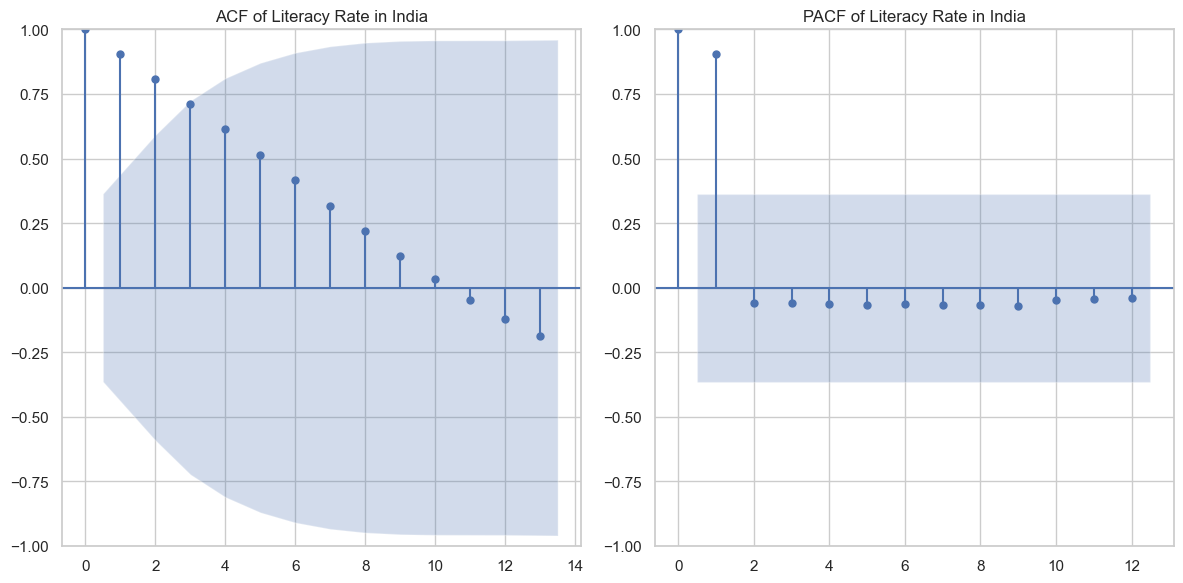

In [5]:
plt.figure(figsize=(12, 6))

# Plot ACF
plt.subplot(1, 2, 1)
plot_acf(final_post_independence_data['persons'], lags=13, ax=plt.gca())
plt.title('ACF of Literacy Rate in India')

# Plot PACF
plt.subplot(1, 2, 2)
plot_pacf(final_post_independence_data['persons'], lags=12, ax=plt.gca())
plt.title('PACF of Literacy Rate in India')

plt.tight_layout()
plt.show()

##### The Autocorrelation Function (ACF) displayed a slow decay, indicating strong correlations across lags—a typical sign of non-stationarity in the dataset.

### <br>Step1: Stationary Check using ADF(Augmented Dickey–Fuller test)
The Augmented Dickey-Fuller (ADF) test was used to statistically verify stationarity.<br>It assume time series as AR(1), which is function of lag(t1). <br>Null Hypothesis: coefficient of lag(t1) is 1(which means unit root is present) <br>Alternate Hypothesis: coefficient of lag(t1) is < 1(No unit root)

In [6]:
from statsmodels.tsa.stattools import adfuller
# Perform the ADF test
def perform_df_test(series):
    result = adfuller(series)

    print('p-value :', result[1])

    # Check stationarity based on the p-value
    if result[1] > 0.05:  # Note: Use result[1] to check the p-value, not result[0]
        print('Series is not stationary')
    else:
        print('Series is stationary')
        
perform_df_test(final_post_independence_data['persons'])

p-value : 0.8271428855073695
Series is not stationary


In [7]:
# First differencing
df_diff = final_post_independence_data
df_diff['persons_diff1'] = df_diff['persons'].diff()

# Dropping the NaN value from the first difference
df_diff = df_diff.dropna()

#Perform the ADF test on the differenced series
perform_df_test(df_diff['persons_diff1'])

p-value : 0.4526161248365417
Series is not stationary


In [8]:
# Second differencing
df_diff['persons_diff2'] = df_diff['persons_diff1'].diff()

# Dropping the NaN value from the first difference
df_diff = df_diff.dropna()

# Perform the ADF test on the differenced series
perform_df_test(df_diff['persons_diff2'])

p-value : 2.7476259532389072e-05
Series is stationary


/var/folders/jw/ztdbrr2d43l_dj3d3hkmjkx80000gn/T/ipykernel_24841/3702893228.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_diff['persons_diff2'] = df_diff['persons_diff1'].diff()


### <br>Step 2: Model Identification & Parameter Estimation

In [9]:
model_A1=ARIMA(df_diff['persons_diff2'],order=(1,2,2))
model_fit_A1=model_A1.fit()
print(model_fit_A1.summary())

                               SARIMAX Results                                
Dep. Variable:          persons_diff2   No. Observations:                   27
Model:                 ARIMA(1, 2, 2)   Log Likelihood                 -20.566
Date:                Tue, 03 Jun 2025   AIC                             49.132
Time:                        18:34:50   BIC                             54.007
Sample:                             0   HQIC                            50.484
                                 - 27                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0664      0.584      0.114      0.910      -1.078       1.211
ma.L1         -1.9887    172.630     -0.012      0.991    -340.338     336.360
ma.L2          0.9908    170.973      0.006      0.9

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


In [10]:
model_A1=ARIMA(df_diff['persons_diff2'],order=(1,2,1))
model_fit_A1=model_A1.fit()
print(model_fit_A1.summary())

                               SARIMAX Results                                
Dep. Variable:          persons_diff2   No. Observations:                   27
Model:                 ARIMA(1, 2, 1)   Log Likelihood                 -23.249
Date:                Tue, 03 Jun 2025   AIC                             52.498
Time:                        18:34:50   BIC                             56.154
Sample:                             0   HQIC                            53.512
                                 - 27                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4246      0.177     -2.395      0.017      -0.772      -0.077
ma.L1         -0.9985     13.775     -0.072      0.942     -27.998      26.001
sigma2         0.3191      4.341      0.074      0.9

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [11]:
model_A1=ARIMA(df_diff['persons_diff2'],order=(1,2,3))
model_fit_A1=model_A1.fit()
print(model_fit_A1.summary())

                               SARIMAX Results                                
Dep. Variable:          persons_diff2   No. Observations:                   27
Model:                 ARIMA(1, 2, 3)   Log Likelihood                 -19.942
Date:                Tue, 03 Jun 2025   AIC                             49.885
Time:                        18:34:50   BIC                             55.979
Sample:                             0   HQIC                            51.575
                                 - 27                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8032      0.977     -0.822      0.411      -2.718       1.112
ma.L1         -0.9888     89.109     -0.011      0.991    -175.640     173.662
ma.L2         -0.9954    122.278     -0.008      0.9

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


#### <br>Based on the AIC comparison, the ARIMA(1, 2, 2) model emerged as the optimal choice.

In [12]:
model_A1=ARIMA(df_diff['persons_diff2'],order=(1,2,2))
model_fit_A1=model_A1.fit()
residuals = model_fit_A1.resid

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


### <br>Step3: Residual Diagnostics

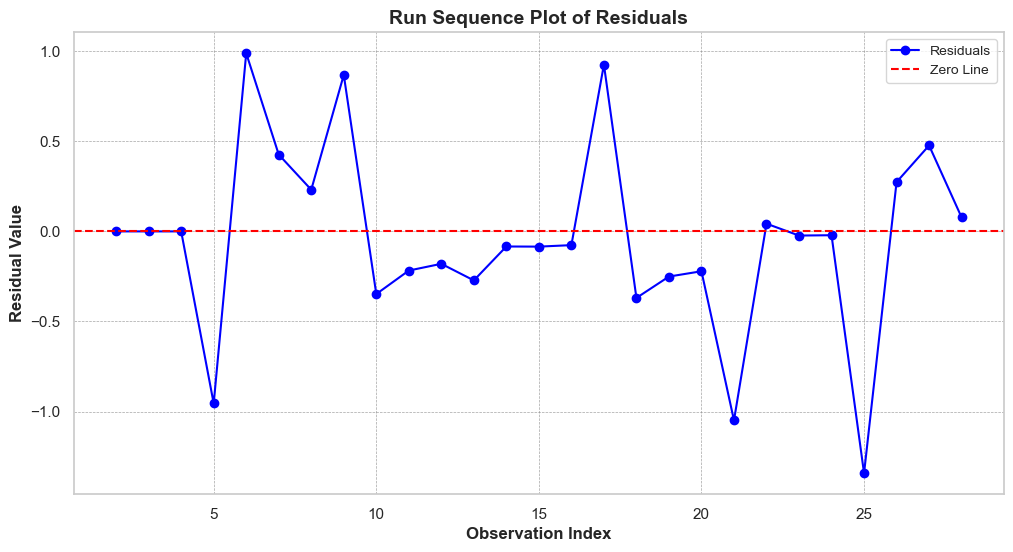

In [13]:
# Run Sequence Plot
plt.figure(figsize=(12, 6))
plt.plot(residuals, marker='o', linestyle='-', color='blue', label='Residuals')
plt.axhline(y=0, color='red', linestyle='--', label='Zero Line')
plt.title('Run Sequence Plot of Residuals', fontsize=14, fontweight='bold')
plt.xlabel('Observation Index', fontsize=12, fontweight='bold')
plt.ylabel('Residual Value', fontsize=12, fontweight='bold')
plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)
plt.legend(loc='upper right', fontsize=10)
plt.show()

##### Residual Analysis<br> Low Error Magnitude: The run sequence plot shows that most of the residuals are in the range (-1,2). Random Residual: Residuals appear randomly scattered around zero, the model is likely doing a good job of fitting the data.<br><br>

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


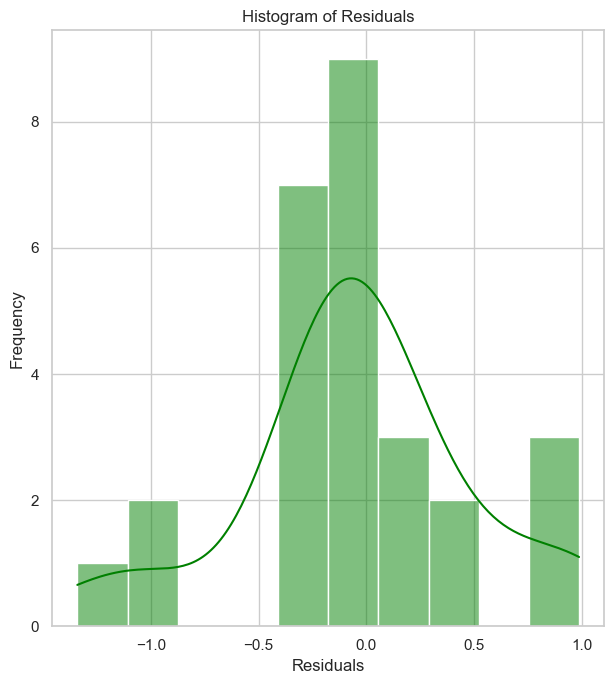

In [14]:
plt.subplot(1, 2, 2)
sns.histplot(residuals, kde=True, color='green', bins=10)
plt.title('Histogram of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

##### The Histogram plot assess the residuals are normally distributed. It suggests that the model is likely capturing the overall structure of the data well.

### <br>Step 4: Forecasting Results

In [15]:
# Forecasting and error metrics (example for the next few years)
forecast_diff2 = model_fit_A1.forecast(steps=5)

# Inverse transform the differenced forecasts to get actual values
# Step 1: Reconstruct first differences from second differences
last_diff1 = df_diff['persons_diff1'].iloc[-1]
forecast_diff1 = [last_diff1 + forecast_diff2.iloc[0]]
for i in range(1, 5):
    forecast_diff1.append(forecast_diff1[-1] + forecast_diff2.iloc[i])

# Step 2: Reconstruct actual values from first differences
last_actual = df_diff['persons'].iloc[-1]
forecast_persons = [last_actual + forecast_diff1[0]]
for i in range(1, 5):
    forecast_persons.append(forecast_persons[-1] + forecast_diff1[i])

# Create future years (2.5 year gap)
last_year = df_diff['year'].iloc[-1]
future_years = [last_year + 2.5 * (i + 1) for i in range(5)]

forecast_df = pd.DataFrame({
    'year': future_years,
    'forecasted_persons': forecast_persons
})
display(forecast_df)

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


,year,forecasted_persons
0,2023.5,79.806611
1,2026.0,80.909238
2,2028.5,81.902782
3,2031.0,82.782509
4,2033.5,83.543708


### <br>Accuracy Metric

In [16]:
# Step 1: Backtest - Fit ARIMA on all data except last 5 points
train = df_diff['persons_diff2'][:-5]
test_actual = df_diff['persons'].iloc[-5:].values  # last 5 actual literacy values
years_forecast = df_diff['year'].iloc[-5:].values

# Fit the model 
model = ARIMA(train, order=(1, 2, 2))
fitted_model = model.fit()
forecast_diff2 = fitted_model.forecast(steps=5)

# Step 3: Inverse 2nd differencing to get actual forecasted values
# Step 3.1: Reconstruct 1st difference
last_diff1 = df_diff['persons_diff1'].iloc[-6]  # one step before test window
forecast_diff1 = [last_diff1 + forecast_diff2.iloc[0]]
for i in range(1, 5):
    forecast_diff1.append(forecast_diff1[-1] + forecast_diff2.iloc[i])

# Step 3.2: Reconstruct actual literacy rates
last_actual = df_diff['persons'].iloc[-6]
forecast_persons = [last_actual + forecast_diff1[0]]
for i in range(1, 5):
    forecast_persons.append(forecast_persons[-1] + forecast_diff1[i])

forecast_persons = np.array(forecast_persons)

# Step 4: Accuracy metrics
errors = test_actual - forecast_persons
ME = np.mean(errors)
RMSE = np.sqrt(mean_squared_error(test_actual, forecast_persons))
MAE = mean_absolute_error(test_actual, forecast_persons)
MPE = np.mean(errors / test_actual) * 100
MAPE = np.mean(np.abs(errors / test_actual)) * 100

# Step 5: Print forecast years and values
print("Forecasted Years and Literacy Rates:")
for i in range(5):
    print(f"Year: {years_forecast[i]} | Forecasted Literacy Rate: {forecast_persons[i]:.2f} | Actual: {test_actual[i]:.2f}")

# Step 6: Print metrics
print("\nForecast Accuracy Metrics:")
print(f"Mean Error (ME): {ME:.4f}")
print(f"Root Mean Squared Error (RMSE): {RMSE:.4f}")
print(f"Mean Absolute Error (MAE): {MAE:.4f}")
print(f"Mean Percentage Error (MPE): {MPE:.2f}%")
print(f"Mean Absolute Percentage Error (MAPE): {MAPE:.2f}%")

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Forecasted Years and Literacy Rates:
Year: 2011.0 | Forecasted Literacy Rate: 73.93 | Actual: 74.04
Year: 2013.5 | Forecasted Literacy Rate: 75.93 | Actual: 75.02
Year: 2016.0 | Forecasted Literacy Rate: 77.67 | Actual: 76.00
Year: 2018.5 | Forecasted Literacy Rate: 79.08 | Actual: 77.30
Year: 2021.0 | Forecasted Literacy Rate: 80.08 | Actual: 78.60

Forecast Accuracy Metrics:
Mean Error (ME): -1.1436
Root Mean Squared Error (RMSE): 1.3383
Mean Absolute Error (MAE): 1.1883
Mean Percentage Error (MPE): -1.49%
Mean Absolute Percentage Error (MAPE): 1.55%


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


| Metric                                    | Value       | Interpretation                                                                                                    |
| ----------------------------------------- | ----------- | ----------------------------------------------------------------------------------------------------------------- |
| **Mean Error (ME)**                       | **-1.1436** | Slight **underestimation** on average (bias). Negative ME means forecasts are generally a bit lower than actuals. |
| **Root Mean Squared Error (RMSE)**        | **1.3383**  | Measures the standard deviation of prediction errors. The lower, the better. This is quite low in your case.      |
| **Mean Absolute Error (MAE)**             | **1.1883**  | On average, forecasts are about **1.19 percentage points** off from the actual literacy rate — very precise.      |
| **Mean Percentage Error (MPE)**           | **-1.49%**  | Forecasts are **1.49% lower** than actual values, again showing a slight bias.                                    |
| **Mean Absolute Percentage Error (MAPE)** | **1.55%**   | Extremely low error percentage — this means your model is predicting **with over 98% accuracy**.                  |

In [17]:
model_A1=ARIMA(df_diff['persons_diff2'],order=(1,2,2))
model_fit_A1=model_A1.fit()
forecast_result = model_fit_A1.get_forecast(steps=5)

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction result

In [18]:
final_post_independence_data

,year,persons,persons_diff1
0,1951.0,18.3300,NaN
1,1953.5,20.8225,2.4925
2,1956.0,23.3150,2.4925
3,1958.5,25.8075,2.4925
4,1961.0,28.3000,2.4925
5,1963.5,29.8375,1.5375
6,1966.0,31.3750,1.5375
7,1968.5,32.9125,1.5375
8,1971.0,34.4500,1.5375
9,1973.5,36.7300,2.2800


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


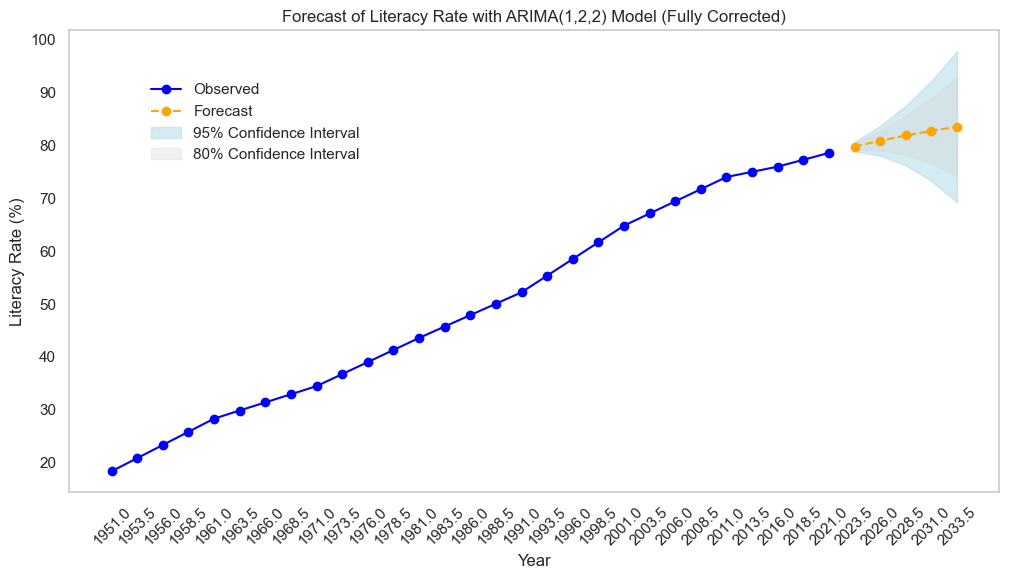

In [19]:
# Forecast for the next 5 steps in the differenced scale
forecast_result = model_fit_A1.get_forecast(steps=5)
forecast_diff2_mean = forecast_result.predicted_mean
forecast_diff2_ci_95 = forecast_result.conf_int(alpha=0.05)
forecast_diff2_ci_80 = forecast_result.conf_int(alpha=0.2)

# Create future years (2.5 year gap)
last_year = df_diff['year'].iloc[-1]
forecast_years = [last_year + 2.5 * (i + 1) for i in range(5)]

# Reverse the differencing to bring the forecast back to the original scale
last_persons_diff1 = df_diff["persons"].diff().iloc[-1]  # Last value of first differencing
last_persons = df_diff["persons"].iloc[-1]

forecast_diff1 = forecast_diff2_mean.cumsum() + last_persons_diff1

# Reconstructing the original series forecast
forecast_persons = forecast_diff1.cumsum() + last_persons

forecast_ci_95_diff1 = forecast_diff2_ci_95.cumsum() + last_persons_diff1
forecast_ci_80_diff1 = forecast_diff2_ci_80.cumsum() + last_persons_diff1

forecast_ci_95_original = forecast_ci_95_diff1.cumsum() + last_persons
forecast_ci_80_original = forecast_ci_80_diff1.cumsum() + last_persons

plt.figure(figsize=(12, 6))
# Plot original series
plt.plot(final_post_independence_data["year"], final_post_independence_data["persons"], label="Observed", marker='o', color="blue")
# Plot forecasted series
plt.plot(forecast_years, forecast_persons, label="Forecast", color="orange", linestyle="--", marker='o')
# Confidence intervals
plt.fill_between(
    forecast_years,
    forecast_ci_95_original.iloc[:, 0],
    forecast_ci_95_original.iloc[:, 1],
    color="lightblue",
    alpha=0.5,
    label="95% Confidence Interval"
)
plt.fill_between(
    forecast_years,
    forecast_ci_80_original.iloc[:, 0],
    forecast_ci_80_original.iloc[:, 1],
    color="lightgray",
    alpha=0.3,
    label="80% Confidence Interval"
)
plt.title("Forecast of Literacy Rate with ARIMA(1,2,2) Model (Fully Corrected)")
plt.xlabel("Year")
plt.ylabel("Literacy Rate (%)")
plt.legend(loc='center', bbox_to_anchor=(0.2, 0.8), frameon=False)
plt.grid()

plt.xticks(
    list(final_post_independence_data["year"]) + forecast_years,  # Combine observed and forecasted years
    rotation=45  # Optional: rotate for readability
)

plt.show()

In [20]:
forecast_table = pd.DataFrame({
    "Year": forecast_years,
    "Forecasted_Literacy": forecast_persons,
    "Lower_95%_CI": forecast_ci_95_original.iloc[:, 0],
    "Upper_95%_CI": forecast_ci_95_original.iloc[:, 1],
    "Lower_80%_CI": forecast_ci_80_original.iloc[:, 0],
    "Upper_80%_CI": forecast_ci_80_original.iloc[:, 1]
})

# Display the forecast table
forecast_table.reset_index(drop=True, inplace=True)
forecast_table

,Year,Forecasted_Literacy,Lower_95%_CI,Upper_95%_CI,Lower_80%_CI,Upper_80%_CI
0,2023.5,79.806611,78.868124,80.745097,79.192968,80.420254
1,2026.0,80.909238,78.078668,83.739808,79.058428,82.760049
2,2028.5,81.902782,76.219789,87.585776,78.186873,85.618692
3,2031.0,82.782509,73.280126,92.284892,76.569235,88.995783
4,2033.5,83.543708,69.247988,97.839428,74.196239,92.891176
